# Figure 4 Final

Notebook to make data for figure 4 for ms <br>
by Cascade Tuholske 2020.02.23

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
#### Load Data
# file path
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly

# HI DATA
FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-FIGDATA.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

# File out
FN_OUT = 'processed/AllDATA-GHS-ERA5-HI406-ZSCORES.csv'

# scale the date in the plot 
scale = 10**9 

In [3]:
#### Drop cities where P1983 == 0
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
#drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city ids for MERRA2 
drop_list = [832, 1732, 5521] # city IDS for ERA5

HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

386920
385526
385424


In [9]:
#### Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/AllDATA-GHS-ERA5-HI406-META.csv'
all_data = pd.read_csv(DATA_IN+meta_fn)
meta = all_data[geog]
meta = meta.drop_duplicates('ID_HDC_G0')

## Merge in meta
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'left')

In [4]:
def z_score(data):
    "mini function to make z scoares"
    mean = np.mean(data)
    sd = np.std(data)
    zscores = (data - mean) / sd
    
    return zscores

In [5]:
def z_residuals(data, col):
    
    """ function finds the z_scores of the residuals from a linear regession.
    Currently set up for city-leve z-scores of the total days per year
    >40.6C. Returns two lists, z-scores for each city and the years for ease
    of plotting.
    
    Args: 
        data = 
        col = column to regress and fine z-score of residuals of, using 'total_days'
    """
    
    years_list = []
    zscores_list = []
    
    years = list(np.unique(data.sort_values('year')['year']))

    for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
        total_days = list(city_df[1].sort_values('year')[col].values)
    
        # Get Data
        X_year = years
        Y_stats = total_days

        # Add Intercept
        X_year_2 = sm.add_constant(X_year)

        # Regress
        model = sm.OLS(Y_stats, X_year_2).fit()

        # residual Z scores 
        zscores = z_score(model.resid) 

        zscores_list.append(zscores)
        years_list.append(years)
        
    return years_list, zscores_list

In [54]:
#### Select Geography (Can change as needed)
location = 'India'
geog = 'CTR_MN_NM'
data = HI_STATS[HI_STATS[geog] == location]
data = HI_STATS

In [55]:
#### Find Z-scores
years_list, zscores_list = z_residuals(data, 'total_days')

Text(0, 0.5, 'z-score')

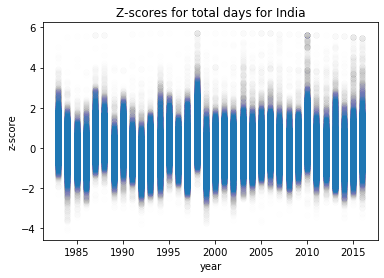

In [57]:
#### Plot it to find years that with the distribution of Z-scores skewed towards heat 
alpha = 0.005
plt.scatter(years_list, zscores_list, alpha = alpha)
plt.title('Z-scores for total days for '+location)
plt.xlabel('year')
plt.ylabel('z-score')

In [45]:
#### Write Out All Data -- Can subset later
data = HI_STATS
years = list(np.unique(data.sort_values('year')['year']))
cols = ['ID_HDC_G0']+years
zscores_df = pd.DataFrame(columns = cols)

In [46]:
#### Write a loop to get scores
row = [] # empty list for rows
years = list(np.unique(data.sort_values('year')['year'])) # get years

for i, city_df in enumerate(data.groupby('ID_HDC_G0')):
    total_days = list(city_df[1].sort_values('year')['total_days'].values)

    # Get Data
    city_id = [city_df[0]]
    X_year = years
    Y_stats = total_days

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit()

    # residual Z scores 
    zscores = z_score(model.resid) 
    
    # Add to data frame
    row = city_id + list(zscores) # tag on the z-scores
    row = pd.Series(row, index = zscores_df.columns)
    
    # append the df
    zscores_df = zscores_df.append(row, ignore_index=True)

In [50]:
#### Add in Meta Data
df_out = zscores_df.merge(meta, on = 'ID_HDC_G0', how = 'left')

In [53]:
#### Save Out
FN_OUT = 'processed/AllDATA-GHS-ERA5-HI406-ZSCORES.csv'
df_out.to_csv(DATA_IN+FN_OUT)